<a href="https://colab.research.google.com/github/bhardwaj1230/Hierarchical-Deep-Reinforcement-Learning/blob/master/HDQN_DQN_maze5X5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Learning Long-range Temporal Abstractions in Hierarchical Deep Reinforcement Learning **

## **Building Maze 5X5**

In [0]:
"""
Reinforcement learning maze example.
Red rectangle:          explorer.
Black rectangles:       hells       [reward = -1].
Yellow bin circle:      paradise    [reward = +1].
All other states:       ground      [reward = 0].
This script is the environment part of this example.
The RL is in RL_brain.py.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
"""
import numpy as np
import time
import sys
if sys.version_info.major == 2:
    import Tkinter as tk
else:
    import tkinter as tk

UNIT = 40   # pixels



class Maze(tk.Tk, object):
    def __init__(self, MAZE_H, MAZE_W, hell_coord, door_coord, oval_coord):
        super(Maze, self).__init__()
        self.MAZE_W = MAZE_W
        self.MAZE_H = MAZE_H
        self.hell_coord = hell_coord
        self.door_coord = door_coord
        self.oval_coord = oval_coord
        self.action_space = ['u', 'd', 'l', 'r']
        self.n_actions = len(self.action_space)
        self.n_features = 13
        self.title('maze')
        self.geometry('{0}x{1}'.format(MAZE_H * UNIT, MAZE_H * UNIT))
        self._build_maze()
        self.counter = 0


    def _build_maze(self):
        self.canvas = tk.Canvas(self, bg='white',
                           height=self.MAZE_H * UNIT,
                           width=self.MAZE_W * UNIT)

        # create grids
        for c in range(0, self.MAZE_W * UNIT, UNIT):
            x0, y0, x1, y1 = c, 0, c, self.MAZE_H * UNIT
            self.canvas.create_line(x0, y0, x1, y1)
        for r in range(0, self.MAZE_H * UNIT, UNIT):
            x0, y0, x1, y1 = 0, r, self.MAZE_H * UNIT, r
            self.canvas.create_line(x0, y0, x1, y1)

        # create origin
        origin = np.array([20, 20])

        # hell
        hell1_center = origin + np.array([self.hell_coord[0]*UNIT, UNIT * self.hell_coord[1]])
        self.hell1 = self.canvas.create_rectangle(
            hell1_center[0] - 15, hell1_center[1] - 15,
            hell1_center[0] + 15, hell1_center[1] + 15,
            fill='black')
            
        # door
        door_center = origin + np.array([UNIT * self.door_coord[0], UNIT * self.door_coord[1]])
        self.door = self.canvas.create_rectangle(
            door_center[0] - 15, door_center[1] - 15,
            door_center[0] + 15, door_center[1] + 15,
            fill='green')

        # create oval
        oval_center = origin + np.array([UNIT*self.oval_coord[0], UNIT*self.oval_coord[1]])
        self.oval = self.canvas.create_oval(
            oval_center[0] - 15, oval_center[1] - 15,
            oval_center[0] + 15, oval_center[1] + 15,
            fill='yellow')
        self.flag = 1

        # create red rect
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')

        # pack all
        self.canvas.pack()

    def reset(self):
        time.sleep(0.01)
        self.update()
        self.canvas.delete(self.rect)
        origin = np.array([20, 20])
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')
        self.flag = 1
        self.counter = 0
        # return observation
        return np.hstack([(np.array([self.flag])),
                          (np.array(self.canvas.coords(self.rect)[:4]) - np.array(self.canvas.coords(self.oval)[:4]))/(self.MAZE_H*UNIT),
                          (np.array(self.canvas.coords(self.rect)[:4]) - np.array(self.canvas.coords(self.hell1)[:4]))/(self.MAZE_H*UNIT),
                          (np.array(self.canvas.coords(self.rect)[:4]) - np.array(self.canvas.coords(self.door)[:4]))/(self.MAZE_H*UNIT),
                          ])

    def step(self, action):
        self.counter += 1
        s = self.canvas.coords(self.rect)
        base_action = np.array([2, 2]) #agent
        if action == 0:   # up
            if s[1] > UNIT:
                base_action[1] -= UNIT
        elif action == 1:   # down
            if s[1] < (self.MAZE_H - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:   # right
            if s[0] < (self.MAZE_W - 1) * UNIT:
                base_action[0] += UNIT
        elif action == 3:   # left
            if s[0] > UNIT:
                base_action[0] -= UNIT

        self.canvas.move(self.rect, base_action[0], base_action[1])  # move agent

        next_coords = self.canvas.coords(self.rect)  # next state

        # reward function
        if(self.flag == 1 and next_coords == self.canvas.coords(self.oval)):
            reward = 1
            done = False
            self.flag = 0
        elif(self.flag == 0 and next_coords == self.canvas.coords(self.door)):
            reward = 2
            done = True
        elif next_coords in [self.canvas.coords(self.hell1)]:
            reward = -1
            done = True
        else:
            reward = 0
            done = False
        
        if(self.counter > 50):
            done = True
        s_ = np.hstack([(np.array([self.flag])),
                        (np.array(next_coords[:4]) - np.array(self.canvas.coords(self.oval)[:4]))/(self.MAZE_H*UNIT),
                        (np.array(next_coords[:4]) - np.array(self.canvas.coords(self.hell1)[:4]))/(self.MAZE_H*UNIT),
                        (np.array(next_coords[:4]) - np.array(self.canvas.coords(self.door)[:4]))/(self.MAZE_H*UNIT),
                        ])
        return s_, reward, done

    def render(self):
        time.sleep(0.01)
        self.update()


In [0]:
"""This file is used for specifying various schedules that evolve over
time throughout the execution of the algorithm, such as:
 - learning rate for the optimizer
 - exploration epsilon for the epsilon greedy exploration strategy
 - beta parameter for beta parameter in prioritized replay
Each schedule has a function `value(t)` which returns the current value
of the parameter given the timestep t of the optimization procedure.
"""


class Schedule(object):
    def value(self, t):
        """Value of the schedule at time t"""
        raise NotImplementedError()


class ConstantSchedule(object):
    def __init__(self, value):
        """Value remains constant over time.
        Parameters
        ----------
        value: float
            Constant value of the schedule
        """
        self._v = value

    def value(self, t):
        """See Schedule.value"""
        return self._v


def linear_interpolation(l, r, alpha):
    return l + alpha * (r - l)


class PiecewiseSchedule(object):
    def __init__(self, endpoints, interpolation=linear_interpolation, outside_value=None):
        """Piecewise schedule.
        endpoints: [(int, int)]
            list of pairs `(time, value)` meanining that schedule should output
            `value` when `t==time`. All the values for time must be sorted in
            an increasing order. When t is between two times, e.g. `(time_a, value_a)`
            and `(time_b, value_b)`, such that `time_a <= t < time_b` then value outputs
            `interpolation(value_a, value_b, alpha)` where alpha is a fraction of
            time passed between `time_a` and `time_b` for time `t`.
        interpolation: lambda float, float, float: float
            a function that takes value to the left and to the right of t according
            to the `endpoints`. Alpha is the fraction of distance from left endpoint to
            right endpoint that t has covered. See linear_interpolation for example.
        outside_value: float
            if the value is requested outside of all the intervals sepecified in
            `endpoints` this value is returned. If None then AssertionError is
            raised when outside value is requested.
        """
        idxes = [e[0] for e in endpoints]
        assert idxes == sorted(idxes)
        self._interpolation = interpolation
        self._outside_value = outside_value
        self._endpoints = endpoints

    def value(self, t):
        """See Schedule.value"""
        for (l_t, l), (r_t, r) in zip(self._endpoints[:-1], self._endpoints[1:]):
            if l_t <= t and t < r_t:
                alpha = float(t - l_t) / (r_t - l_t)
                return self._interpolation(l, r, alpha)

        # t does not belong to any of the pieces, so doom.
        assert self._outside_value is not None
        return self._outside_value


class LinearSchedule(object):
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
        """Linear interpolation between initial_p and final_p over
        schedule_timesteps. After this many timesteps pass final_p is
        returned.
        Parameters
        ----------
        schedule_timesteps: int
            Number of timesteps for which to linearly anneal initial_p
            to final_p
        initial_p: float
            initial output value
        final_p: float
            final output value
        """
        self.schedule_timesteps = schedule_timesteps
        self.final_p = final_p
        self.initial_p = initial_p

    def value(self, t):
        """See Schedule.value"""
        fraction = min(float(t) / self.schedule_timesteps, 1.0)
        return self.initial_p + fraction * (self.final_p - self.initial_p)

In [0]:
import operator


class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.
        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)

## **Replay Buffer**

In [0]:
import numpy as np
import random


class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, alpha):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha >= 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def add(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super().add(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        for _ in range(batch_size):
            # TODO(szymon): should we ensure no repeats?
            mass = random.random() * self._it_sum.sum(0, len(self._storage) - 1)
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, beta):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)

In [0]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [0]:
get_available_gpus()

['/device:GPU:0']

# **Deep Q-Network**

In [0]:
import numpy as np
import tensorflow as tf


# Deep Q Network off-policy
class DeepQNetwork:
    with tf.device('/device:GPU:0'):
        def __init__(
                self,
                n_actions,
                n_features,
                Name,
                optimizer = 'rmsprop',
                momentum = None,
                learning_rate=0.01,
                opt_decay=0.99,
                reward_decay=0.99,
                e_greedy=0.9,
                e_greedy_max=0.99,
                e_greedy_increment=None,
                e_greedy_iter=5e4,                                  		                   
                replace_target_iter=300,
                memory_size=500,
                batch_size=32,
                output_graph=False,
                prioritized_replay=False,
                prioritized_replay_alpha=0.6,
                prioritized_replay_beta0=0.4,
                prioritized_replay_beta_iters=None,
                prioritized_replay_eps=1e-6,  
                ):
            with tf.variable_scope(Name):
                self.n_actions = n_actions
                self.n_features = n_features
                self.Name=Name
                self.lr = learning_rate
                self.gamma = reward_decay
                self.epsilon_max = e_greedy_max
                self.replace_target_iter = replace_target_iter
                self.memory_size = memory_size
                self.batch_size = batch_size
                self.epsilon_increment = e_greedy_increment
                # self.epsilon = e_greedy if e_greedy_increment is not None else self.epsilon_max
                # new
                self.e_greedy_iter = e_greedy_iter
                self.epsilon = LinearSchedule(self.e_greedy_iter,
                                              initial_p=e_greedy,
                                              final_p=self.epsilon_max)
                self.prioritized_replay = prioritized_replay
                self.prioritized_replay_alpha = prioritized_replay_alpha
                self.prioritized_replay_beta0 = prioritized_replay_beta0
                self.prioritized_replay_beta_iters = prioritized_replay_beta_iters
                self.prioritized_replay_eps = prioritized_replay_eps
                self.optimizer = optimizer
                self.momentum = momentum
                self.opt_decay = opt_decay
                if self.optimizer is 'momentum':
                    assert self.momentum is not None
                if self.optimizer is 'rmpsprop':
                    assert self.opt_decay is not None


                # total learning step
                self.learn_step_counter = 0

                # initialize zero memory [s, a, r, s_]
                # self.memory = np.zeros((self.memory_size, n_features * 2 + 2))
                # new
                self.memory = self._build_replay_buffer()

                # consist of [target_net, evaluate_net]
                self._build_net()

                t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_net')
                e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='eval_net')

                with tf.variable_scope('soft_replacement'):
                    self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

                self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

                if output_graph:
                    # $ tensorboard --logdir=logs
                    tf.summary.FileWriter("logs/", self.sess.graph)

                self.sess.run(tf.global_variables_initializer())
                self.cost_his = []

        def _build_net(self):
            # ------------------ all inputs ------------------------
            self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input State
            self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')  # input Next State
            self.r = tf.placeholder(tf.float32, [None, ], name='r')  # input Reward
            self.a = tf.placeholder(tf.int32, [None, ], name='a')  # input Action
            self.weights = tf.placeholder(tf.float32, [None, ], name='weights')  # input Action

            w_initializer, b_initializer = tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)

            with tf.variable_scope(self.Name):
                # ------------------ build evaluate_net ------------------
                with tf.variable_scope('eval_net'):
                    e1 = tf.layers.dense(self.s, 20, tf.nn.relu, kernel_initializer=w_initializer,
                                         bias_initializer=b_initializer, name='e1')
                    self.q_eval = tf.layers.dense(e1, self.n_actions, kernel_initializer=w_initializer,
                                                  bias_initializer=b_initializer, name='q')

                # ------------------ build target_net ------------------
                with tf.variable_scope('target_net'):
                    t1 = tf.layers.dense(self.s_, 20, tf.nn.relu, kernel_initializer=w_initializer,
                                         bias_initializer=b_initializer, name='t1')
                    self.q_next = tf.layers.dense(t1, self.n_actions, kernel_initializer=w_initializer,
                                                  bias_initializer=b_initializer, name='t2')

                with tf.variable_scope('q_target'):
                    q_target = self.r + self.gamma * tf.reduce_max(self.q_next, axis=1, name='Qmax_s_')    # shape=(None, )
                    self.q_target = tf.stop_gradient(q_target)
                with tf.variable_scope('q_eval'):
                    a_indices = tf.stack([tf.range(tf.shape(self.a)[0], dtype=tf.int32), self.a], axis=1)
                    self.q_eval_wrt_a = tf.gather_nd(params=self.q_eval, indices=a_indices)    # shape=(None, )
                with tf.variable_scope('TD_error'):
                    self.td_errors = tf.abs(self.q_target - self.q_eval_wrt_a, name='TD_error')
                with tf.variable_scope('loss'):
                    self.loss = tf.reduce_mean(self.weights*tf.squared_difference(self.q_target, self.q_eval_wrt_a))
                with tf.variable_scope('train'):
                    if self.optimizer is 'rmsprop':
                        self._train_op = tf.train.RMSPropOptimizer(self.lr, self.opt_decay).minimize(self.loss)
                    elif self.optimizer is 'momentum':
                        self._train_op = tf.train.MomentumOptimizer(self.lr,self.momentum).minimize(self.loss)   
                    elif self.optimizer is 'adam':
                        self._train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
                    else: print('!!!')       

        def _build_replay_buffer(self):
            # Create the replay buffer
            if self.prioritized_replay:
                replay_buffer = PrioritizedReplayBuffer(self.memory_size, alpha=self.prioritized_replay_alpha)
                if self.prioritized_replay_beta_iters is None:
                    self.prioritized_replay_beta_iters = self.prioritized_replay_iter
                self.beta_schedule = LinearSchedule(self.prioritized_replay_beta_iters,
                                                    initial_p=self.prioritized_replay_beta0,
                                                    final_p=1.0)
            else:
                replay_buffer = ReplayBuffer(self.memory_size)
                self.beta_schedule = None

            return replay_buffer


        def choose_action(self, observation, test=False):
            # to have batch dimension when feed into tf placeholder
            observation = observation[np.newaxis, :]

            if np.random.uniform() < self.epsilon.value(self.learn_step_counter) or test:
                # forward feed the observation and get q value for every actions
                actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
                action = np.argmax(actions_value)
            else:
                action = np.random.randint(0, self.n_actions)
            return action

        def learn(self):
            # check to replace target parameters
            if self.learn_step_counter % self.replace_target_iter == 0:
                self.sess.run(self.target_replace_op)
            # print('\ntarget_params_replaced\n')
            if self.learn_step_counter == self.e_greedy_iter:
                print('\n',self.Name, 'achieved e_greedy_max!!!!!!!!!!!!!!!!!!!!!!')

            # new
            # Minimize the error in Bellman's equation on a batch sampled from replay buffer.
            if self.prioritized_replay:
                experience = self.memory.sample(self.batch_size, beta=self.beta_schedule.value(self.learn_step_counter))
                (obses_t, actions, rewards, obses_tp1, dones, weights, batch_idxes) = experience
            else:
                obses_t, actions, rewards, obses_tp1, dones = self.memory.sample(self.batch_size)
                weights, batch_idxes = np.ones_like(rewards), None


            _, cost, td_errors = self.sess.run(
                [self._train_op, self.loss, self.td_errors],
                feed_dict={
                    self.s: obses_t,
                    self.a: actions,
                    self.r: rewards,
                    self.s_: obses_tp1,
                    self.weights: weights,
                })

            self.cost_his.append(cost)

            # new
            # update memory
            if self.prioritized_replay:
                new_priorities = np.abs(td_errors) + self.prioritized_replay_eps
                self.memory.update_priorities(batch_idxes, new_priorities)

        # increasing epsilon
            #self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
            self.learn_step_counter += 1

        def plot_cost(self):
            import matplotlib.pyplot as plt
            plt.plot(np.arange(len(self.cost_his)), self.cost_his)
            plt.ylabel('Cost')
            plt.xlabel('training steps')
            plt.show()

    """if __name__ == '__main__':
        DQN = DeepQNetwork(3,4, output_graph=True)
    """

In [0]:
#!apt-get install python3-tk
!pip install pyvirtualdisplay
!sudo apt-get install xvfb


from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
%matplotlib inline

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


# **HDQN**

In [0]:
import numpy as np
import torch
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd

def train_hdqn(seed, file):
    # maze game
    MAZE_H=5
    MAZE_W=5
    hell_coord = [4,2]
    door_coord = [0,4]
    oval_coord = [2,0]
    #Agent @ [2,2]

    np.random.seed(seed)
    tf.set_random_seed(seed)

    # maze game
    env = Maze(MAZE_H, MAZE_W, hell_coord, door_coord, oval_coord)
    n_goals = 3
    max_episode = 10000
    controller_start = 200
    meta_controller_start = 20000
    controller = DeepQNetwork(env.n_actions, env.n_features + 1, 'controller',
                              optimizer='adam',
                              momentum=0.9,
                              learning_rate=1e-3,
                              opt_decay=0.99,
                              reward_decay=0.99,
                              e_greedy=0,
                              e_greedy_max=0.99,
                              e_greedy_increment=1e-4,
                              e_greedy_iter=5e3,
                              replace_target_iter=200,
                              memory_size=5000,
                              output_graph=False,
                              prioritized_replay=False,
                              prioritized_replay_alpha=0.6,
                              prioritized_replay_beta0=0.4,
                              prioritized_replay_beta_iters=1e5,
                              prioritized_replay_eps=1e-6
                              )

    meta_controller = DeepQNetwork(n_goals, env.n_features, 'meta_controller',
                                   optimizer='adam',
                                   momentum=0.9,
                                   learning_rate=1e-3,
                                   opt_decay=0.99,
                                   reward_decay=0.99,
                                   e_greedy=0,
                                   e_greedy_max=0.99,
                                   e_greedy_increment=1e-4,
                                   e_greedy_iter=1e3,
                                   replace_target_iter=200,
                                   memory_size=500,
                                   output_graph=False,
                                   prioritized_replay=True,
                                   prioritized_replay_alpha=0.6,
                                   prioritized_replay_beta0=0.4,
                                   prioritized_replay_beta_iters=1e3,
                                   prioritized_replay_eps=1e-6,
                                   )

    def play_maze():
        def goal_reached(g, s):
            return ((s[2 * g + 1] == 0) and (s[2 * g + 2] == 0))

        s = env.reset()
        g = meta_controller.choose_action(s, test=True)
        score = 0
        while True:
            env.render()
            a = controller.choose_action(np.hstack((s, g)), test=True)
            s_, r, done = env.step(a)
            score += r
            if done:
                break
            s = s_
            if goal_reached(g, s):
                g = meta_controller.choose_action(s, test=True)
        return score

    def run_maze(max_episode):
        def goal_reached(g, s):
            return ((s[2 * g + 1] == 0) and (s[2 * g + 2] == 0))

        def goal_distance(g, s):
            return np.sqrt(s[2 * g + 1] ** 2 + s[2 * g + 2] ** 2)

        def reward(g, s_, done):

            return 1 if goal_reached(g, s_) else -1

        step = 0
        score_list = []
        avescore_list = []
        testscore_list = []
        score_eps = []
        control_meta_loss = []
        goal_metacontrol = []
        flag = [False, False, False, False]
        for episode in tqdm(range(max_episode)):
            # initial observation
            s = env.reset()
            score = 0
            g = meta_controller.choose_action(s)
            Done = False
            while True:
                F = 0
                s0 = s
                episode_step = 1
                while True:
                    env.render()
                    a = controller.choose_action(np.hstack((s, g)))
                    s_, f, done = env.step(a)
                    score += f
                    r = reward(g, s_, done)
                    controller.memory.add(np.hstack((s, g)), a, r, np.hstack((s_, g)), done)
                    if (step > controller_start) and (step % 5 == 0):
                        controller.learn()
                        
                    if step == meta_controller_start:
                        print('\nmeta controller start learn~~~~~~~~~~~~~~~~~~~~')
                    if step == controller_start:
                        print('\ncontroller start learn~~~~~~~~~~~~~~~~~~~~~~~~~~')

                    F = F + f
                    s = s_
                    step = step + 1

                    if done:
                        Done = True
                        break
                    if goal_reached(g, s):
                        break

                    episode_step = episode_step + 1
                meta_controller.memory.add(s0, g, F, s, done)
                if step > meta_controller_start:
                    meta_controller.learn()
                if Done:
                    break
                g = meta_controller.choose_action(s)
            
            
            
            if g > 2:
              print('\n\n Episode and Goal :',episode, g)
            goal_metacontrol.append((episode, g))
            
            
            
            score_list.append(score)
            score_eps.append((episode, score))
            
            meta_loss = np.mean(meta_controller.cost_his[np.max(
                        [0, meta_controller.learn_step_counter - 100]):meta_controller.learn_step_counter])
            control_loss = np.mean(controller.cost_his[np.max(
                        [0, controller.learn_step_counter - 100]):controller.learn_step_counter])
            
            control_meta_loss.append((episode,meta_loss,control_loss))
            
            
            
            if (episode > 0 and episode % 50 == 0):
                avescore = np.average(np.array(score_list[-50:]))
                avescore_list.append(avescore)
                print("\nepisode %d : average score = %f" % (episode, avescore))
                testscore = play_maze()
                testscore_list.append(testscore)
                print("episode %d : test score = %f\n" % (episode, testscore))

                if avescore > 2.5 and not flag[0]:
                    flag[0] = True
                    with open(file, 'a+') as f:
                        f.write('train average score achieves 2.5 (' + str(avescore) + ')\n')

                elif avescore > 0.5 and not flag[1]:
                    flag[1] = True
                    with open(file, 'a+') as f:
                        f.write('train average score achieves 0.5 (' + str(avescore) + ')\n')

                if testscore > 2.5 and not flag[2]:
                    flag[2] = True
                    with open(file, 'a+') as f:
                        f.write('test score achieves 2.5 (' + str(testscore) + ')\n')
                elif testscore > 0.5 and not flag[3]:
                    flag[3] = True
                    with open(file, 'a+') as f:
                        f.write('test score achieves 0.5 (' + str(testscore) + ')\n')

            if (episode > 0 and episode % 10 == 0):
                if step > controller_start:
                    print('controller loss:', control_loss)
                if step > meta_controller_start:
                    print('meta controller loss:',meta_loss)
                    
        # end of game
        print('game over')
        env.destroy()
        plt.plot(range(len(avescore_list)), avescore_list)
        plt.show()
        np.savetxt("./SEED_%d_avescore_log.txt" % (seed), avescore_list)
        np.savetxt("./SEED_%d_testscore_log.txt" % (seed), testscore_list)
        
        score_eps = pd.DataFrame(score_eps)
        score_eps.columns = ['episode','score']
        score_eps.to_csv('./score_eps.csv')

        control_meta_loss = pd.DataFrame(control_meta_loss)
        control_meta_loss.columns = ['episode','meta_loss','control_loss']
        control_meta_loss.to_csv('./control_meta_loss.csv')
        
        goal_metacontrol = pd.DataFrame(goal_metacontrol)
        goal_metacontrol.columns = ['episode', 'meta_controller_goal']
        goal_metacontrol.to_csv('./goal_metacontrol.csv')

    env.after(100, run_maze, max_episode)
    env.mainloop()
    controller.plot_cost()
    meta_controller.plot_cost()
    

if __name__ == "__main__":
    seed_list = np.random.randint(10000, size=1)
    file = r'.\maze33_hdqn_score.txt'
    for s in seed_list:
        print('SEED=', s)
        with open(file, 'a+') as f:
            f.write('\nSEED=' + str(s) + '\n')
        train_hdqn(seed=s, file=file)


# **DQN**

In [0]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt




def train_dqn(seed, file):
    # maze game
    MAZE_H=5
    MAZE_W=5
    hell_coord = [4,2]
    door_coord = [0,4]
    oval_coord = [2,0]
    #Agent @ [2,2]

    np.random.seed(seed)
    tf.set_random_seed(seed)

    # maze game
    env = Maze(MAZE_H, MAZE_W, hell_coord, door_coord, oval_coord)
    max_episode = 10000
    dqn_start = 5000
    dqn = DeepQNetwork(env.n_actions, env.n_features, 'dqn',
                              optimizer='adam',
                              momentum=0.9,
                              learning_rate=0.00025,
                              opt_decay=0.99,
                              reward_decay=0.99,
                              e_greedy=0,
                              e_greedy_max=0.99,
                              e_greedy_increment=1e-4,
                              e_greedy_iter=5e3,
                              replace_target_iter=200,
                              memory_size=10000,
                              output_graph=False,
                              prioritized_replay=True,
                              prioritized_replay_alpha=0.6,
                              prioritized_replay_beta0=0.4,
                              prioritized_replay_beta_iters=1e5,
                              prioritized_replay_eps=1e-6
                              )

    def play_maze():
        
        def goal_reached(g, s):
            return (s[1] == g)

        s = env.reset()
        score = 0
        while True:
            env.render()
            a = dqn.choose_action(s, test=True)
            s_, r, done = env.step(a)
            score += r
            if done:
                break
            s = s_

        return score

    def run_maze(max_episode):
        step = 0
        score_list = []
        avescore_list = []
        testscore_list = []
        score_eps = []
        flag = [False, False, False, False]
        for episode in range(max_episode):
            # initial observation
            s = env.reset()
            score = 0
            while True:
                env.render()
                a = dqn.choose_action(s)
                s_, r, done = env.step(a)
                score += r
                dqn.memory.add(s, a, r, s_, done)

                if (step > dqn_start) and (step % 5 == 0):
                    dqn.learn()
                if step == dqn_start:
                    print('\ndqn start learn~~~~~~~~~~~~~~~~~~~~')

                s = s_
                step = step + 1
                if done:
                    break

            score_list.append(score)
            score_eps.append((episode, score))
            if (episode > 0 and episode % 50 == 0):
                # average score
                avescore = np.average(np.array(score_list[-50:]))
                avescore_list.append(avescore)
                print("\nepisode %d : average score = %f" % (episode, avescore))
                # test score
                testscore = 0
                for i in range(5):
                    testscore += play_maze()
                testscore /= 5
                testscore_list.append(testscore)
                print("episode %d : test score = %f\n" % (episode, testscore))

                # logs
                if avescore > 0.1 and not flag[0]:
                    flag[0] = True
                    with open(file, 'a+') as f:
                        f.write('train average score achieves 0.1 (' + str(avescore) + ')\n')


                elif avescore > 0.02 and not flag[1]:
                    flag[1] = True
                    with open(file, 'a+') as f:
                        f.write('train average score achieves 0.02 (' + str(avescore) + ')\n')

                if testscore > 0.1 and not flag[2]:
                    flag[2] = True
                    with open(file, 'a+') as f:
                        f.write('test score achieves 0.1 (' + str(testscore) + ')\n')
                elif testscore > 0.02 and not flag[3]:
                    flag[3] = True
                    with open(file, 'a+') as f:
                        f.write('test score achieves 0.02 (' + str(testscore) + ')\n')

            # loss
            if (episode > 0 and episode % 10 == 0):
                if step > dqn_start:
                    print('dqn loss:', np.mean(dqn.cost_his[np.max(
                        [0, dqn.learn_step_counter - 100]):dqn.learn_step_counter]))

        # end of game
        print('game over')
        env.destroy()
        plt.plot(range(len(avescore_list)), avescore_list)
        plt.show()
        np.savetxt("./SEED_%d_avescore_log.txt" % (seed), avescore_list)
        np.savetxt("./SEED_%d_testscore_log.txt" % (seed), testscore_list)
        
        score_eps = pd.DataFrame(score_eps)
        score_eps.columns = ['episode','score']
        score_eps.to_csv('./score_eps.csv')

    env.after(100, run_maze, max_episode)
    env.mainloop()
    dqn.plot_cost()

if __name__ == "__main__":
    #seed = 9109
    seed = np.random.randint(10000, size=1)
    print('SEED=', seed)
    file = r'.\maze33_dqn_score.txt'
    with open(file, 'a+') as f:
        f.write('\nSEED=' + str(seed) + '\n')
    train_dqn(seed=seed, file=file)


## **Plots**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
%matplotlib inline

import numpy as np 

from matplotlib import rc
import matplotlib.patches as mpatches

rc('figure', figsize=(9, 6))
rc('axes', titlesize = 20, labelsize = 18, titleweight = 'bold')
rc('xtick', labelsize = 16, color = 'black')
rc('ytick', labelsize = 16, color = 'black')
rc('legend', fontsize = 16, handlelength = 2)



def plot_fnc(data):
    
    
    means = pd.Series(data).rolling(10, min_periods=10).mean()
    stds = pd.Series(data).rolling(10, min_periods=10).std()/4
    means.plot()
    plt.fill_between(range(len(means)),means - stds, means + stds, alpha=0.2)

    """error = np.random.normal(data, 20)
    data.plot()
    plt.fill_between(data.index, data + error[0], data - error[0], alpha=0.4)"""

    plt.xlabel('Episode * 50')
    plt.ylabel('Average Reward')

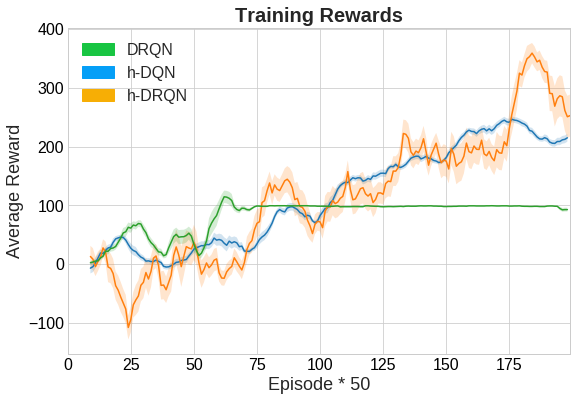

In [0]:
import pandas as pd
hdq_ave_rwd = pd.read_csv('SEED_9109_avescore_log.csv')
plot_fnc(hdq_ave_rwd['rewards']*100)

hdrq_ave_rwd = pd.read_csv('HDRQN_SEED_9109_avescore_log.csv')
plot_fnc(hdrq_ave_rwd['rewards']*100)

dq_ave_rwd = pd.read_csv('SEED_3102_avescore_log.txt', header=-1)
dq_ave_rwd.columns = ['rewards']
plot_fnc(dq_ave_rwd['rewards']*100)

plt.title('Training Rewards')
red_patch = mpatches.Patch(color ='#059FF7', label='h-DQN')
blue_patch = mpatches.Patch(color ='#F7AE05', label='h-DRQN')
purple_patch = mpatches.Patch(color ='#18C542', label='DRQN')
plt.legend(handles=[purple_patch, red_patch, blue_patch])


Text(0.5, 1.0, 'Testing Rewards')

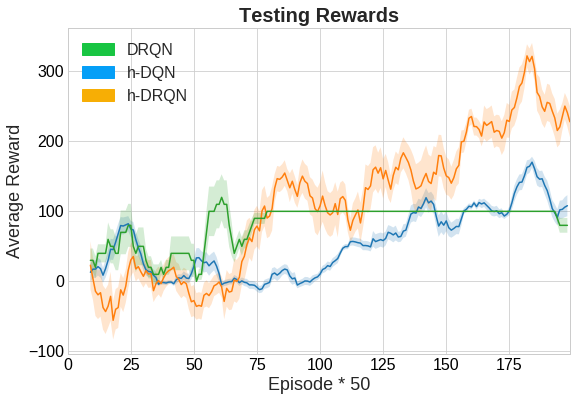

In [0]:
ave_test_rwd = pd.read_csv('SEED_9109_testscore_log.csv')
plot_fnc(ave_test_rwd['rewards']*100)

ave_test_rwd = pd.read_csv('HDRQN_SEED_9109_testscore_log.csv')
plot_fnc(ave_test_rwd['rewards']*100)


dq_test_rwd = pd.read_csv('SEED_3102_testscore_log.txt', header=-1)
dq_test_rwd.columns = ['rewards']
plot_fnc(dq_test_rwd['rewards']*100)


red_patch = mpatches.Patch(color ='#059FF7', label='h-DQN')
blue_patch = mpatches.Patch(color ='#F7AE05', label='h-DRQN')
purple_patch = mpatches.Patch(color ='#18C542', label='DRQN')
plt.legend(handles=[purple_patch, red_patch, blue_patch])

plt.legend(handles=[purple_patch, red_patch, blue_patch])

plt.title('Testing Rewards')

Text(0.5, 1.0, 'HDQN Cumulative Reward')

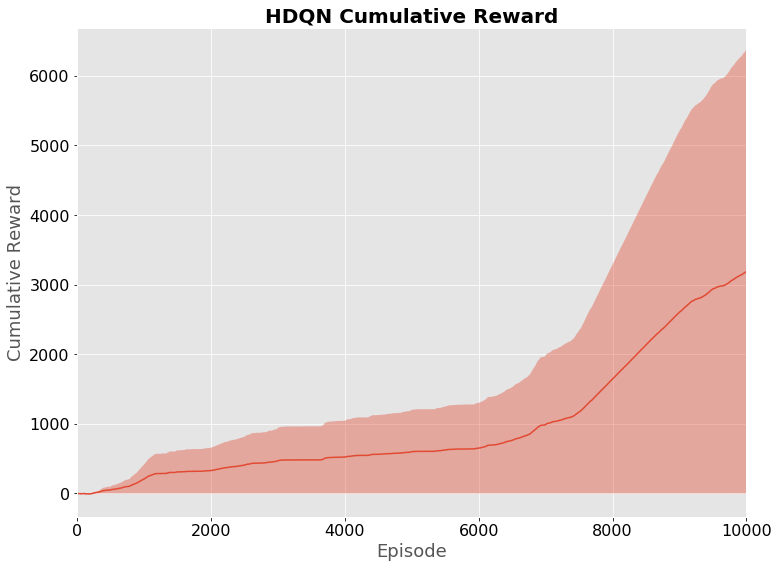

In [0]:

def plot_fnc(data):
    error = np.random.normal(data, 0.1)
    data.plot()
    plt.fill_between(data.index, data + error, data - error, alpha=0.4)

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    
score = pd.read_csv('hdqn_score.csv')
data = pd.DataFrame(score['score'].cumsum().values)
data.columns = ['rewards']
plot_fnc(data['rewards'])

plt.title('HDQN Cumulative Reward')

Text(0.5, 1.0, 'HDQN Model Loss')

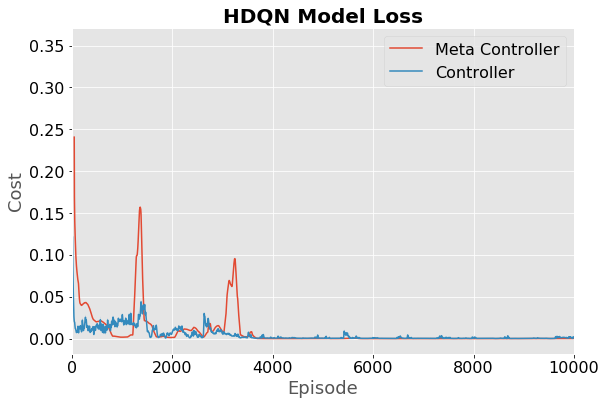

In [0]:
loss = pd.read_csv('control_meta_loss.csv')
loss.columns = ['index', 'episode', 'Meta Controller', 'Controller']
plot_fnc(loss['Meta Controller'])
plot_fnc(loss['Controller'])
plt.ylabel('Cost')
plt.xlabel('Episode')
plt.legend()


plt.title('HDQN Model Loss')

# **MDP Plots**

In [0]:
def plot_fnc(data):
    
    
    means = pd.Series(data).rolling(10, min_periods=10).mean()
    stds = pd.Series(data).rolling(10, min_periods=10).std()/4
    means.plot()
    plt.fill_between(range(len(means)),means - stds, means + stds, alpha=0.2)

    """error = np.random.normal(data, 20)
    data.plot()
    plt.fill_between(data.index, data + error[0], data - error[0], alpha=0.4)"""

    plt.xlabel('Episode * 100')
    plt.ylabel('Average Reward')

Text(0.5, 1.0, '6-DSDP Rewards')

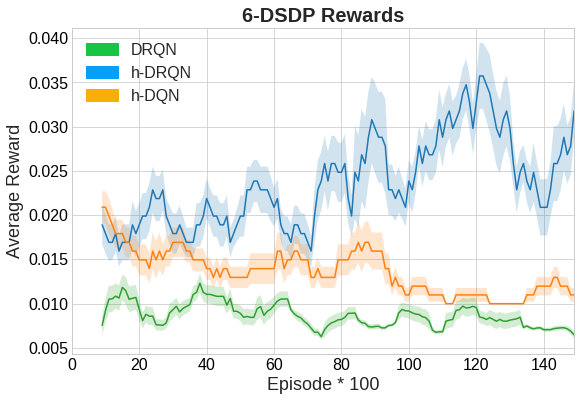

In [0]:
hdqn_mdp = pd.read_csv('hdqn.csv')
plot_fnc(hdqn_mdp.groupby(np.arange(len(hdqn_mdp))//100).mean()['rewards'])

hdrqn_mdp = pd.read_csv('hdrqn.csv')
plot_fnc(hdrqn_mdp.groupby(np.arange(len(hdrqn_mdp))//100).mean()['rewards'])

drqn_mdp = pd.read_csv('new_drqn.csv')
plot_fnc(drqn_mdp.groupby(np.arange(len(drqn_mdp))//100).mean()['rewards'])

red_patch = mpatches.Patch(color ='#059FF7', label='h-DRQN')
blue_patch = mpatches.Patch(color ='#F7AE05', label='h-DQN')
purple_patch = mpatches.Patch(color ='#18C542', label='DRQN')
plt.legend(handles=[purple_patch, red_patch, blue_patch])

plt.legend(handles=[purple_patch, red_patch, blue_patch],loc = 'best' )

plt.title('6-DSDP Rewards')

Text(0.5, 1.0, 'MDP Rewards')

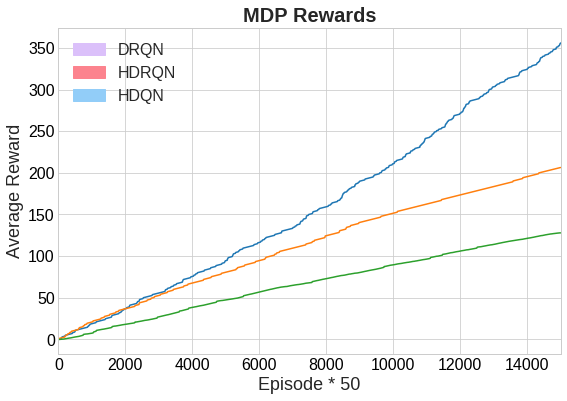

In [0]:
hdqn_mdp = pd.read_csv('hdqn.csv')
plot_fnc(hdqn_mdp['rewards'].cumsum())

hdrqn_mdp = pd.read_csv('hdrqn.csv')
plot_fnc(hdrqn_mdp['rewards'].cumsum())

drqn_mdp = pd.read_csv('new_drqn.csv')
plot_fnc(drqn_mdp['rewards'].cumsum())

red_patch = mpatches.Patch(color ='#FC838E', label='HDRQN')
blue_patch = mpatches.Patch(color ='#92CDF8', label='HDQN')
purple_patch = mpatches.Patch(color ='#DBC0FA', label='DRQN')
plt.legend(handles=[purple_patch, red_patch, blue_patch])

plt.title('MDP Rewards')

In [0]:
states = pd.read_csv('states.csv')

Text(0.5, 1.0, 'Number of visits in 6,4-DSDP (averaged over 1000 episodes)')

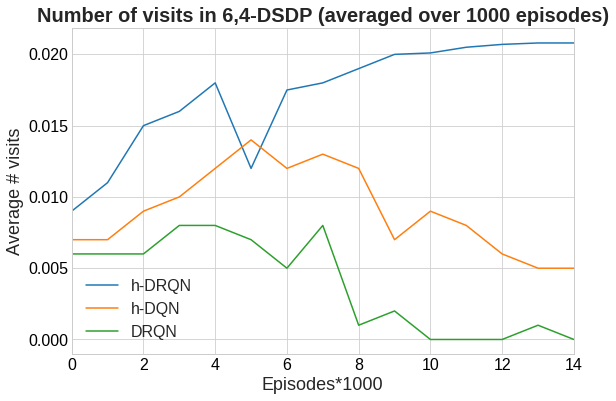

In [0]:
(states/1000).plot()
plt.xlabel('Episodes*1000')
plt.ylabel('Average # visits')
plt.title('Number of visits in 6,4-DSDP (averaged over 1000 episodes)')

In [0]:
noise = np.random.normal(0.01,0.08, [15000])

In [0]:
noise = np.linspace(0.001,0.01,15000)

In [0]:
def plot_fnc(data):
    
    means = pd.Series(data).rolling(32, min_periods=10).mean()
    stds = pd.Series(data).rolling(32, min_periods=10).std()/4
    means.plot()
    plt.fill_between(range(len(means)),means - stds, means + stds, alpha=0.2)

    plt.xlabel('Episode * 100')
    plt.ylabel('Average Reward')

In [0]:
"""hdqn_mdp = pd.read_csv('hdqn.csv')
hdqn_mdp_mean = hdqn_mdp.groupby(np.arange(len(hdqn_mdp))//100).mean()['rewards']
hdqn_mdp_mean.to_csv('./hdqn_mdp_mean.csv')

hdrqn_mdp = pd.read_csv('hdrqn.csv')
hdrqn_mdp_mean = hdrqn_mdp.groupby(np.arange(len(hdrqn_mdp))//100).mean()['rewards']
hdrqn_mdp_mean.to_csv('./hdrqn_mdp_mean.csv')
"""
drqn_mdp = pd.read_csv('new_drqn.csv')
drqn_mdp_mean = drqn_mdp.groupby(np.arange(len(drqn_mdp))//100).mean()['rewards']
drqn_mdp_mean.to_csv('./drqn_mdp_mean.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, '6,4-DSDP Rewards')

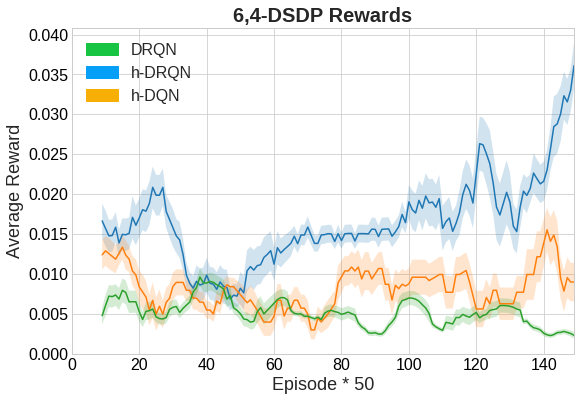

In [0]:
hdqn_mdp_mean = pd.read_csv('hdqn_mdp_mean.csv', header=0)
plot_fnc(hdqn_mdp_mean['rewards'])

hdrqn_mdp_mean = pd.read_csv('hdrqn_mdp_mean.csv', header=0)
plot_fnc(hdrqn_mdp_mean['rewards'])

drqn_mdp_mean = pd.read_csv('drqn_mdp_mean.csv', header=0)
plot_fnc(drqn_mdp_mean['rewards'])


red_patch = mpatches.Patch(color ='#059FF7', label='h-DRQN')
blue_patch = mpatches.Patch(color ='#F7AE05', label='h-DQN')
purple_patch = mpatches.Patch(color ='#18C542', label='DRQN')
plt.legend(handles=[purple_patch, red_patch, blue_patch])

plt.legend(handles=[purple_patch, red_patch, blue_patch],loc = 'best' )

plt.title('6,4-DSDP Rewards')